# **CS 181 HW5** (Solutions)
---

## Problem 2

#### Initialize data and parameters

Consider a specific example of when we have $K = 3$ component Gamma distributions. Let's initialize the initial parameter values for $\theta$ and $\beta_k$ as follows:
$$
\begin{align*}
  \theta_k &=  1/K, \\
  \beta_k & = k/K.
\end{align*}
$$

Note that we usually initialize $\theta$ and $\beta_k$ randomly. However, by fixing the initial $\theta$ and $\beta_k$, EM becomes deterministic which makes debugging (and grading) easier.



In [25]:
import torch
import torch.distributions as ds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

x = torch.load('data.pt').flatten()

In [26]:
# # uncomment to use numpy (optional)
import numpy as np
from scipy.stats import gamma
from scipy.special import logsumexp, gammaln

### Part 1

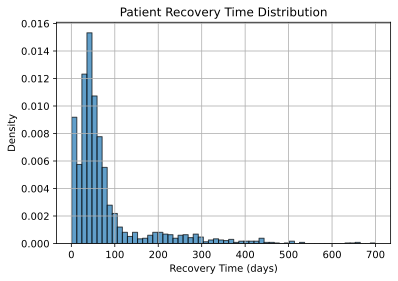

In [27]:
plt.figure(figsize=(6, 4))
plt.hist(x.numpy(), bins=60, density=True, alpha=0.7, edgecolor='black')
plt.title('Patient Recovery Time Distribution')
plt.xlabel('Recovery Time (days)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

### Part 2

#### **Todo:** implement the E-step

In [28]:
alpha = 5.0

In [30]:
log_gamma_alpha = torch.lgamma(torch.tensor(alpha))

def e_step(theta, betas):
    theta = theta.double()
    betas = betas.double()
    xv = x.unsqueeze(1)
    log_gamma_pdf = ((alpha - 1) * torch.log(xv + 1e-16)
               - xv / betas.unsqueeze(0)
               - alpha * torch.log(betas).unsqueeze(0)
               - log_gamma_alpha)
    log_theta = torch.log(theta + 1e-16)
    U = log_theta.unsqueeze(0) + log_gamma_pdf
    return torch.softmax(U, dim=1)

#### **Todo:** implement the M-step

In [31]:
def m_step(q):
    N = q.shape[0]
    theta = q.sum(dim=0) / N
    betas= (q * x.unsqueeze(1)).sum(dim=0) / (alpha * q.sum(dim=0))
    return theta, betas


#### **Todo:** implement log likelihood

In [32]:
def log_px(x, theta, betas):
    xv = x.unsqueeze(1)
    log_pdf = (
        (alpha - 1) * torch.log(xv + 1e-16)
        - xv / betas.unsqueeze(0)
        - alpha * torch.log(betas).unsqueeze(0)
        - log_gamma_alpha
    )
    log_theta = torch.log(theta + 1e-16)
    U = log_theta.unsqueeze(0) + log_pdf
    return torch.logsumexp(U, dim=1)

def log_likelihood(theta, betas):
    return log_px(x, theta, betas).sum().item()

#### **Todo:** implement EM algorithm

In [33]:
def run_em(theta, betas, iterations=1000, verbose=True):
    theta = theta.clone().double()
    betas = betas.clone().double()
    loglike_old = -float('inf')
    for i in range(iterations):
        q = e_step(theta, betas)
        theta, betas = m_step(q)
        loglike = log_likelihood(theta, betas)
        loglike_old = loglike
    return theta, betas

### Part 3

In [34]:
def make_overlay_plot(theta, betas):
    x_test = torch.linspace(0.01, x.max(), 1000)
    prob = log_px(x_test, theta, betas).exp()
    #prob = log_px(x_test.unsqueeze(-1), theta, betas).exp()
    # prob = np.exp(log_px(x_test.unsqueeze(-1), theta, betas))  # use this line for numpy
    ll = log_likelihood(theta, betas)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    fig.subplots_adjust(top=0.7)
    fig.suptitle(f'theta = {theta}\nbeta = {betas}\nlog likelihood = {ll:.3e}')
    
    ax.hist(x.T, bins=100, color='tomato', alpha=0.5, density=True, label='Dataset')
    ax.plot(x_test, prob, color='royalblue', label='Gamma mixture')
    
    ax.set_title(f'Dataset and Gamma mixture (K={len(theta)})')
    ax.set_xlabel('Recovery time (hours)')
    ax.set_ylabel('Density')
    ax.legend()

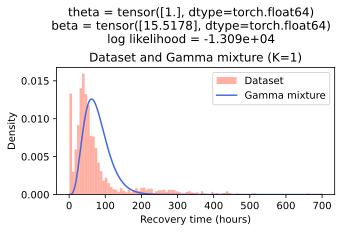

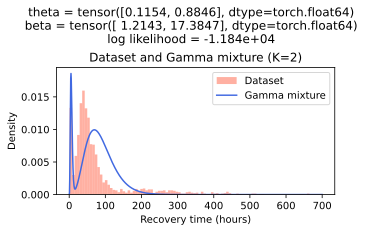

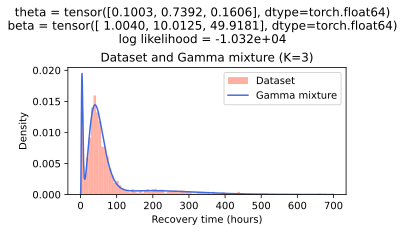

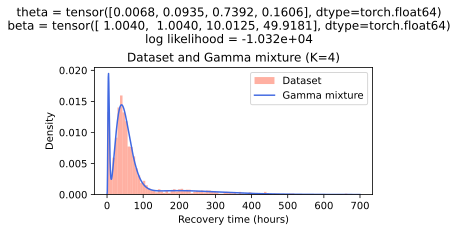

In [35]:
alpha = 5.0
for K in range(1,5):
    theta0 = torch.ones(K) / K
    betas0 = (torch.arange(K) + 1) / K
    theta, betas = run_em(theta0, betas0, verbose=False)
    make_overlay_plot(theta, betas)
    # plt.savefig(f'p2_3_{K}mixtures.pdf', bbox_inches='tight')

---
## Problem 3

#### Initialize data:

In [51]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)  # download MNIST
N = 6000 

x = mnist_trainset.data[:N]  # select N datapoints
x = x.flatten(1)             # flatten the images
x = x.float()                # convert pixels from uint8 to float
# x = x.numpy()              # uncomment to use numpy (optional)

#### **Todo:** implement PCA

*Hint: see `.linalg.svd()`*

In [54]:
def pca(x, n_comps=500):
    # center data
    x_centered = x - x.mean(dim=0)             # (N, D)

    # compute SVD
    U, S, Vp = torch.linalg.svd(x_centered, full_matrices=False)

    # find values
    eigvals = (S**2)[:n_comps]        # (n_comps,)
    pc  = Vp[:n_comps]            # (n_comps, D)
    return eigvals, pc

#### **Todo:** calculate cumulative fraction of variance

*Hint: see `.cumsum()`*

In [44]:
def calc_cfvs(eigvals):
    cumulative = eigvals.cumsum(dim = 0)
    total = eigvals.sum()
    cfvs = cumulative / total
    return cfvs

#### **Todo:** calculate mean squared L2 norm reconstruction losses

In [45]:
def calc_errs(x, pcomps):
    N, D = x.shape
    x_mean = x.mean(dim=0)            # (D,)
    # mean error
    mean_error = ((x - x_mean)**2).sum(dim=1)  # (N,)
    mean_error = mean_error.mean().item()

    # pca with 10 comps
    Xc = x - x_mean                   # centered
    comps10 = pcomps[:10]             # (10, D)
    coeffs = Xc @ comps10.T           # (N, 10)
    recon  = coeffs @ comps10         # (N, D)
    pcomp_error = ((Xc - recon)**2).sum(dim=1)
    pcomp_error = pcomp_error.mean().item()

    return mean_error, pcomp_error

#### Plot and print errors:

In [46]:
def plot_pic(pic, ax, title=''):
    x = pic.reshape(28, 28)
    ax.imshow(x, cmap='binary')
    ax.set_title(title)
    ax.axis('off')

def make_plots(eigvals, cfvs, x_mean, pcomps):
    # plot eigenvals and cfvs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(eigvals, color='tomato')
    ax1.set_title('Eigenvalues')
    ax2.plot(cfvs, color='tomato')
    ax2.set_title('CFVs')
    # fig.savefig('p3_cfvs.pdf')

    # plot mean
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_pic(x_mean, ax, title='Mean')
   #  fig.savefig('p3_mean.pdf')

    # plot top 10 pcomps
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        plot_pic(pcomps[i], axes.flat[i], title=f'PC index {i}')
    # fig.savefig('p3_pcomps.pdf')

Reconstruction error (using mean): 3.436023e+06
Reconstruction error (using mean and top 10 pcomps): 1.731315e+06


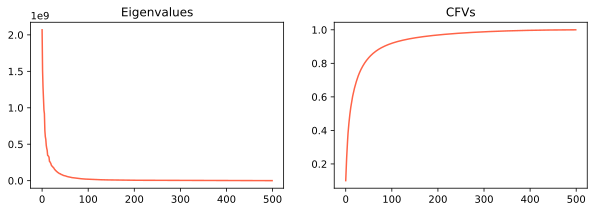

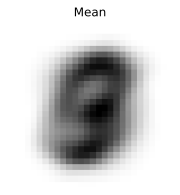

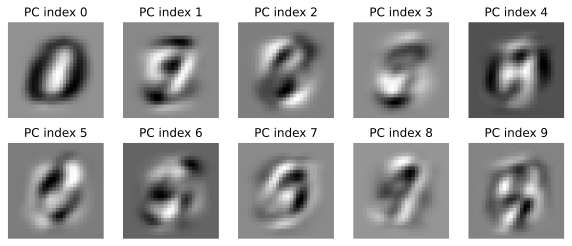

In [55]:
# do PCA
eigvals, pcomps = pca(x)

# calculate CFVs
fcvs = calc_cfvs(eigvals)

# print errors
err_mean, err_pcomp = calc_errs(x, pcomps)
print(f'Reconstruction error (using mean): {err_mean:3e}')  # 3.436022e+06
print(f'Reconstruction error (using mean and top 10 pcomps): {err_pcomp:3e}')  # 1.731315e+06

# make plots
make_plots(eigvals, fcvs, x.mean(0), pcomps)
